# Mining Twitter

Projet de Web Mining - CY Tech

Joshua BONACORSI

In [1]:
pip install textstat --user

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install tweepy --user

In [3]:
pip install transformers --user

In [4]:
pip install datasets --user

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install gensim --user

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import sklearn
import nltk
from nltk.corpus import stopwords
from collections import  Counter
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

import tweepy

import matplotlib.pyplot as plt
import numpy as np
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud, STOPWORDS
import nltk

import wordcloud, textstat

from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords
import string

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix, classification_report

from sklearn.metrics import accuracy_score, f1_score
from transformers import Trainer

from datasets import load_dataset, Dataset
from transformers import AutoTokenizer
from transformers import TrainingArguments
from transformers import AutoModelForSequenceClassification

from sklearn.metrics import accuracy_score, f1_score

from transformers import pipeline
from transformers.pipelines.pt_utils import KeyDataset
from tqdm.auto import tqdm

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.decomposition import PCA

## Connecting to twitter API

In [7]:
api_key = "5bryRcTjdbTNgKijAQ87iJIbo"
api_key_secret = "2fvy2oQKMyKQ6SZ49BPfpJzJZR3kd2jV0mnr19QzvsUvb9ESw8"

bearer_token = "AAAAAAAAAAAAAAAAAAAAALRhmwEAAAAAsBN5eXSuO6YSkGkRzjHtpK%2FZpJ8%3DJVUOtw2kuIqBbMPjBvOgiKPZV5ZjONYQlA6wrYshuAG5jzo2Nw"
bearer_token_2 = "AAAAAAAAAAAAAAAAAAAAAAdDPQEAAAAAYRCxLKdh%2BTmEOzt6txzHwRVFEYo%3D38kYdoCYRiTQbuHwDZUfdK6BUOExzjUr372KJjIqQ187itlBD8"

access_token = "1403176151468683267-RKus7wxq9UZ7JUKFYijm8misHqLrI1"
access_token_secret = "p6RQd3P4gMSYNrPQD31HsP9rRkU63tRYyO5H6oJ2rZvps"

free_api = tweepy.Client(access_token=access_token,
                         access_token_secret=access_token_secret,
                         consumer_key=api_key,
                         consumer_secret=api_key_secret)

basic_api = tweepy.Client(bearer_token_2, 
                          wait_on_rate_limit = True)

In [8]:
free_api.get_me()

Response(data=<User id=1403176151468683267 name=JoJo username=RiemannUchiha>, includes={}, errors=[], meta={})

In [9]:
basic_api.get_users_followers(id=1403176151468683267)
#basic_api.get_liked_tweets(id=1403176151468683267)
#basic_api.get_retweeters(id=1648773576839819273)


Response(data=[<User id=1458211667976900612 name=Océane username=its_oceeee>, <User id=1546564062632464385 name=Sarah username=sarah_ramirez98>, <User id=1643230022763941889 name=Genevieve username=Nehir1328078646>, <User id=1177233237049061376 name=cam username=KrackScofield>, <User id=1629127612223340546 name=J_Stone🦑 username=JStone92301440>, <User id=1431286880692314124 name=rayanm91_ username=rayanm91_>, <User id=1187769011838377984 name=back2 username=back2__>, <User id=1427370073702944776 name=Victoire username=MonsejourC>, <User id=3351027363 name=Lyca. username=Lyca10_>, <User id=1029355281967468544 name=nahsudiV BMS / KC username=pulikutty_>, <User id=1476242038467223553 name=Mohalak username=AkhyDeter69>, <User id=4189363515 name=DAVE username=ProdDave>, <User id=1424988942940712975 name=itsyace username=itsyaceeee>, <User id=710523442651594752 name=Nico username=akayy_Dono>, <User id=2766292373 name=nth username=NATHAN_PLQ>, <User id=1148169952383438850 name=🌸Max la mitrail

## Data Preparation

In [10]:
q = '#France -is:retweet'

search_results = basic_api.search_all_tweets(query=q,max_results=500).data

dict_data = {
    "id" : [int(x.id) for x in search_results],
    "text" : [str(x.text) for x in search_results]
}

In [11]:
df = pd.DataFrame(dict_data)

df

,id,text
0,1648848201384951809,"@CFDT @CfdtBerger #Agent du #gouvernement ,nou..."
1,1648848128341168130,Nitrites Stop ou Encore ? #lobby #France #Euro...
2,1648847440798433281,@MrPilou @AlertesInfos TOUS les personnes logi...
3,1648847282173779968,Ce qu'il est parto faire en #Chine. Déposer la...
4,1648847051994673153,► ROSE ROSE - Charlotte on https://t.co/GzXTo...
...,...,...
495,1648793208913113088,🇫🇷 NOAA 18 19-04-2023 22:40 Max Elev: 40° E Su...
496,1648793200859963398,Ovo na cara do @EmmanuelMacron!\nVive le Franc...
497,1648793177833324547,🇫🇷 NOAA 18 19-04-2023 22:40 Max Elev: 40° E Su...
498,1648792999709790208,#MMTLP #StolenRetirement #SECknew #FINRAknew #...


## Data Exploration

### Global dataset statistics

In [12]:
# On recupere tous les tweets sous la forme d'un corpus geant (giant_str)

giant_str = ' '.join(df["text"])

class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, tweets):
        return [self.wnl.lemmatize(t) for t in word_tokenize(tweets)]

lm = LemmaTokenizer()
giant_str_tokenized = lm(giant_str)

In [13]:
# Calcul de la diversité lexicale (tend vers 1 si aucune repetition de mots)

word_count = len(giant_str_tokenized)
unique_word_count = len(set(giant_str_tokenized))
lexical_diversity = unique_word_count/word_count

print("Word_count : ",word_count)
print("Unique_word_count : ",unique_word_count)
print("Lexical_diversity : ",lexical_diversity)

Word_count :  21030
Unique_word_count :  5572
Lexical_diversity :  0.2649548264384213


### Basic Exploration

<AxesSubplot:>

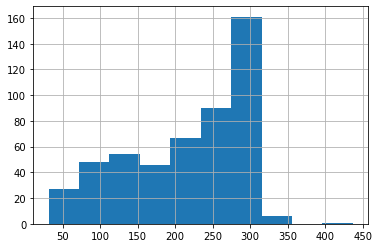

In [14]:
# Str length per tweet histogram

df['text'].str.len().hist()

<AxesSubplot:>

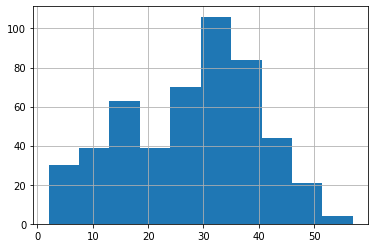

In [21]:
# Nb of words per tweet hist

df['text'].str.split().map(lambda x: len(x)).hist()

<AxesSubplot:>

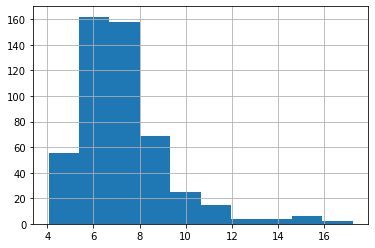

In [22]:
# Average word length per tweet hist

df["text"].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x)).hist()

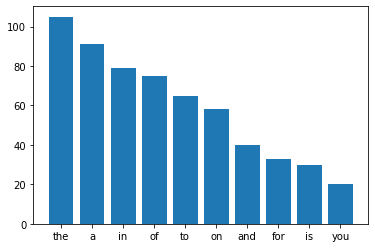

In [23]:
# plot stop words

def plot_top_stopwords_barchart(text):
    stop=set(stopwords.words('english'))
    
    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]
    from collections import defaultdict
    dic=defaultdict(int)
    for word in corpus:
        if word in stop:
            dic[word]+=1
            
    top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
    x,y=zip(*top)
    plt.bar(x,y)
    
plot_top_stopwords_barchart(df["text"])

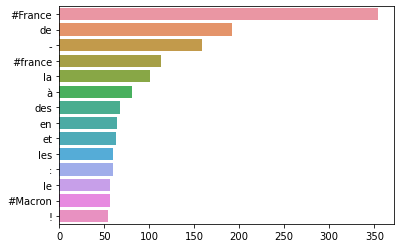

In [24]:
# plot top20 non stop words

def plot_top_non_stopwords_barchart(text):
    stop=set(stopwords.words('english'))
    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]
    counter=Counter(corpus)
    most=counter.most_common()
    x, y=[], []
    for word,count in most[:20]:
        if (word not in stop):
            x.append(word)
            y.append(count)
    sns.barplot(x=y,y=x)
    
plot_top_non_stopwords_barchart(df["text"])

### N-Gram Exploration

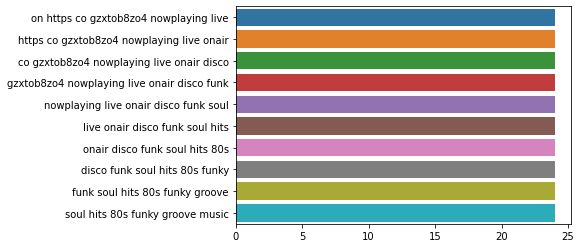

In [25]:
# plot top10 n_gram 

def plot_top_ngrams_barchart(text, n=2):
    stop=set(stopwords.words('french'))

    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    def _get_top_ngram(corpus, n=None):
        vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) 
                      for word, idx in vec.vocabulary_.items()]
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq[:10]

    top_n_bigrams=_get_top_ngram(text,n)[:10]
    x,y=map(list,zip(*top_n_bigrams))
    sns.barplot(x=y,y=x)

plot_top_ngrams_barchart(df["text"],6)

### Wordcloud

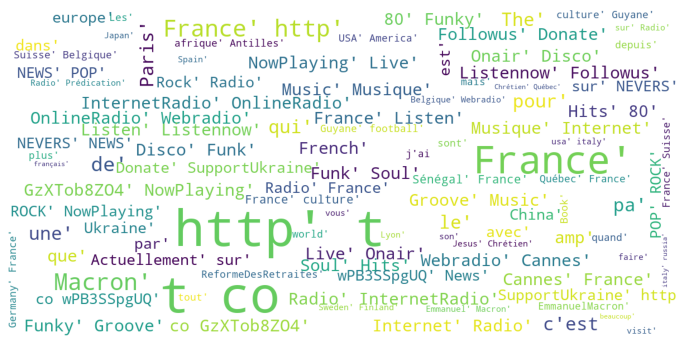

In [26]:
def plot_wordcloud(text):
    stop=set(stopwords.words('english'))
    def _preprocess_text(text):
        corpus=[]
        stem=PorterStemmer()
        lem=WordNetLemmatizer()
        for news in text:
            words=[w for w in word_tokenize(news) if (w not in stop)]
            words=[lem.lemmatize(w) for w in words if len(w)>2]
            corpus.append(words)
        return corpus
    corpus=_preprocess_text(text)
    wordcloud = WordCloud(
        background_color='white',
        stopwords=set(STOPWORDS),
        max_words=100,
        max_font_size=30, 
        scale=3,
        random_state=1)
    wordcloud=wordcloud.generate(str(corpus))
    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    plt.imshow(wordcloud)
    plt.show()

plot_wordcloud(df['text'])

## Sentiment Analysis

### Create huggingface dataset

In [27]:
dataset = Dataset.from_pandas(df)

In [28]:
pipe = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


### Infer

In [29]:
sentiments = []
scores = []

for out in tqdm(pipe(KeyDataset(dataset, "text"))):
    sentiments.append(out['label'].lower())
    scores.append(out["score"])

df["sentiment"] = pd.Series(sentiments)
df["score"] = pd.Series(scores)

  0%|          | 0/500 [00:00<?, ?it/s]

### Results

In [30]:
df.sentiment.value_counts()

negative    440
positive     60
Name: sentiment, dtype: int64

## Dimensionality reduction & Word Similarity Vizualisation

### Word Embedding with Word2Vec

In [31]:
from gensim.models import Word2Vec
from gensim.test.utils import common_texts

final_stopwords_list = stopwords.words('english') + stopwords.words('french') + list(string.punctuation)

texts = [lm(tweet) for tweet in df.text.tolist()]
texts_non_stopwords = []

for list_word in texts: 
    cleaned_list = []
    for word in list_word :
        if not word.lower() in final_stopwords_list: 
            cleaned_list.append(word.lower())
    texts_non_stopwords.append(cleaned_list)   

word2vec = Word2Vec(texts_non_stopwords, min_count=2, window=4)
print(word2vec)

Word2Vec<vocab=1360, vector_size=100, alpha=0.025>


In [32]:
vocabulary = word2vec.wv.index_to_key
print(vocabulary)
print(len(vocabulary))

['http', 'france', 'macron', 'usa', '’', 'radio', 'paris', 'germany', 'news', 'nowplaying', 'rock', '...', 'italy', 'ukraine', 'russia', 'webradio', 'europe', 'uk', 'pa', 'music', 'live', "c'est", 'china', 'actuellement', '..', 'newyork', 'amp', 'cannes', '``', '🇫🇷', 'musique', 'groove', 'french', 'canada', 'onlineradio', 'internetradio', 'internet', 'funky', '80', 'hits', 'listen', 'supportukraine', 'listennow', 'funk', 'disco', 'soul', 'onair', 'donate', 'india', 'spain', 'art', '//t.co/gzxtob8zo4', 'followus', '►', 'pop', 'nevers', '//t.co/wpb3sspguq', 'reformedesretraites', "''", 'culture', 'afrique', 'america', 'guyane', 'australia', 'england', '2023', 'london', '--', 'poland', 'football', "'s", 'like', 'sénégal', "j'ai", 'alsace', 'love', 'f1', 'emmanuelmacron', 'français', 'israel', 'youtube', 'dubai', 'tout', 'lyon', 'ha', 'antilles', 'california', 'denmark', 'scotland', 'world', 'quand', 'us', 'unitedkingdom', 'sweden', 'matmatah', 'belgique', 'travel', 'suisse', 'plus', 'merc

In [33]:
# Print manually most similars words

def get_most_similar(word):
    return(word2vec.wv.most_similar(word.lower()))

print(get_most_similar("Macron"))
print(get_most_similar("Soirée"))

[('france', 0.9557591676712036), ('http', 0.9492921233177185), ('paris', 0.938226580619812), ('...', 0.9366807341575623), ('pa', 0.929501473903656), ('news', 0.9278725385665894), ('germany', 0.9274436831474304), ('radio', 0.9271424412727356), ('’', 0.9248673915863037), ('poland', 0.923845112323761)]
[('travelgram', 0.36317822337150574), ('robe', 0.3593069314956665), ('tout', 0.3527297079563141), ('bfmtv', 0.3520095646381378), ('sunset', 0.3433525860309601), ('souleyman', 0.3417506515979767), ('2023', 0.32972222566604614), ('reformedesretraites', 0.32270121574401855), ('cdnpoli', 0.3159160017967224), ('mexico', 0.31393811106681824)]


In [34]:
pca = PCA(n_components=2)
pca_results = pca.fit_transform(word2vec.wv.get_normed_vectors())
pca_df = pd.DataFrame(pca_results, index=vocabulary, columns=["pc1","pc2"])
pca_df

,pc1,pc2
http,0.599672,-0.002707
france,0.601651,-0.004687
macron,0.574769,0.015480
usa,0.561829,-0.029744
’,0.556390,-0.053857
...,...,...
christ,0.092301,0.082095
islam,-0.153820,-0.128682
cela,-0.256157,0.022163
available,-0.132850,-0.073764


<AxesSubplot:xlabel='pc1', ylabel='pc2'>

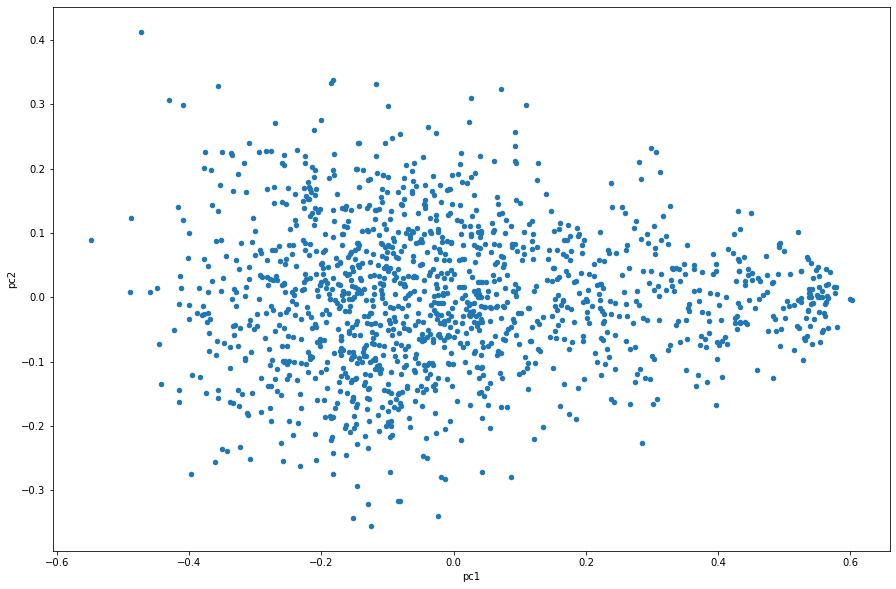

In [35]:
pca_df.plot(x='pc1',y='pc2',kind="scatter",figsize=(15, 10))

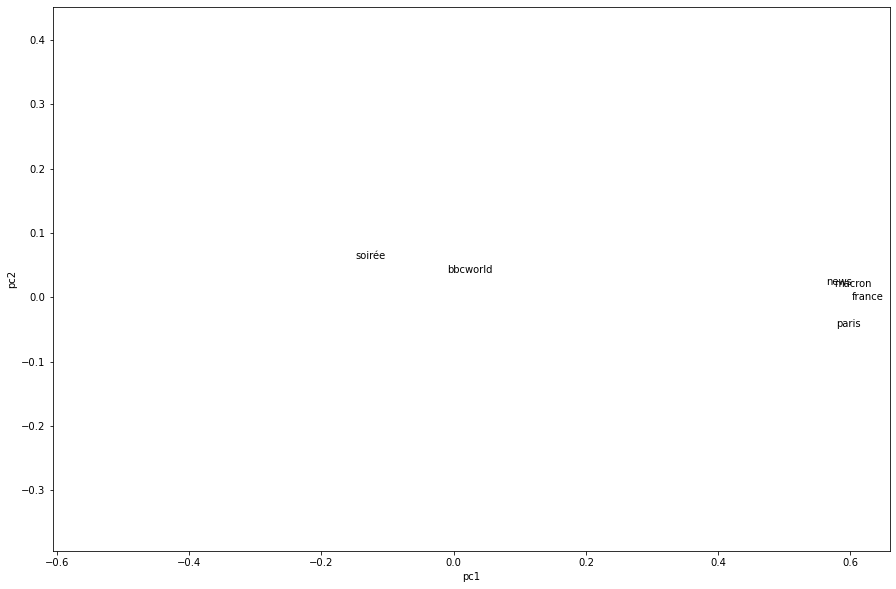

In [36]:
ax = pca_df.plot(x='pc1',y='pc2',kind="scatter",figsize=(15, 10),alpha=0)
for txt in pca_df.index:
    if txt in ["macron", "france", "paris","news","soirée","bbcworld","pentagon"]:
        x = pca_df.pc1.loc[txt]
        y = pca_df.pc2.loc[txt]
        ax.annotate(txt, (x,y))
plt.show()

No handles with labels found to put in legend.


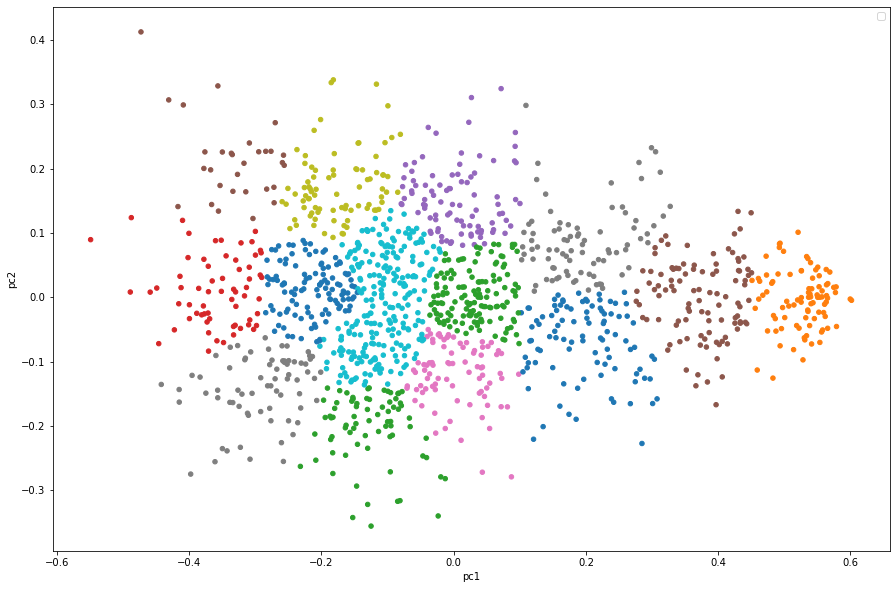

In [67]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=15, random_state=42)
kmeans.fit(pca_df) 

pca_df_bis = pca_df.copy()
pca_df_bis["group"] = pd.Series(kmeans.labels_,index=pca_df_bis.index.tolist())

ax = pca_df_bis.plot.scatter(x='pc1', y='pc2', c='group',figsize=(15, 10),colormap='tab10', colorbar=False)
plt.show()

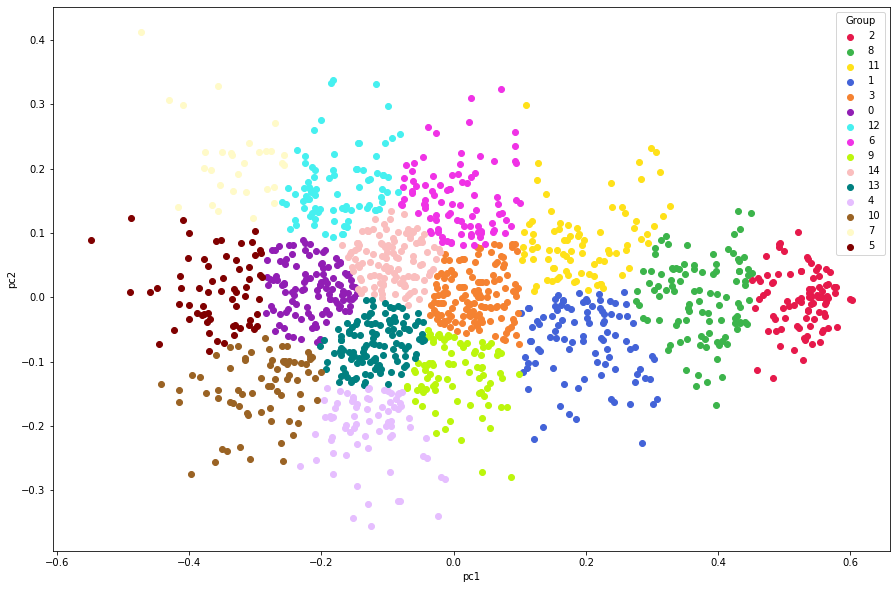

In [71]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 10))

# Liste des groupes uniques
unique_groups = pca_df_bis['group'].unique()

# Liste de 15 couleurs différentes
colors = [
    '#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0',
    '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8',
    '#800000'
]

# Créez un dictionnaire pour mapper les groupes aux couleurs
color_map = dict(zip(unique_groups, colors))

# Tracez chaque groupe séparément
for group in unique_groups:
    group_data = pca_df_bis[pca_df_bis['group'] == group]
    ax.scatter(group_data['pc1'], group_data['pc2'], c=[color_map[group]], label=group)

# Affichez la légende
ax.legend(title="Group")

# Configurez les étiquettes des axes
ax.set_xlabel('pc1')
ax.set_ylabel('pc2')

plt.show()
